# Prepare for colab

In [ ]:
!pip install catboost
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 2.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Upload API Token

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/backups/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


## Download and unzip dataset

In [ ]:
!kaggle datasets download -d ryuina/amex-fe-plus3
!unzip /content/amex-fe-plus3.zip

100% 3.93G/3.94G [01:41<00:00, 48.9MB/s]
100% 3.94G/3.94G [01:41<00:00, 41.7MB/s]
Archive:  /content/amex-fe-plus2.zip
  inflating: test_fe_plus_plus.parquet  
  inflating: train_fe_plus_plus.parquet  


In [ ]:
!kaggle competitions download -c amex-default-prediction -f sample_submission.csv
!unzip /content/sample_submission.csv.zip

 28% 9.00M/32.4M [00:00<00:01, 17.7MB/s]
100% 32.4M/32.4M [00:00<00:00, 52.9MB/s]
Archive:  /content/sample_submission.csv.zip
  inflating: sample_submission.csv   


# Settings

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from tqdm import tqdm

import os
import gc; gc.enable()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
VER=9
SEED = 42
FOLDS = 5

cat_features = ["B_30", "B_38", "D_114", "D_116", "D_117", "D_120", "D_126", "D_63", "D_64", "D_66", "D_68"]

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(SEED)

In [ ]:
train = pd.read_parquet("/content/train_fe_plus_plus.parquet")
# train = train.reset_index(level=0)
test = pd.read_parquet("/content/test_fe_plus_plus.parquet")
# test = test.reset_index(level=0)

In [ ]:
cat_features_last = [f"{cf}_last" for cf in cat_features]

le_encoder = LabelEncoder()
for categorical_feature in cat_features_last:
    train[categorical_feature] = le_encoder.fit_transform(train[categorical_feature])
    test[categorical_feature] = le_encoder.transform(test[categorical_feature])

In [ ]:
# https://www.kaggle.com/code/ragnar123/amex-lgbm-dart-cv-0-7963
# Round last float features to 2 decimal place
float_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
float_cols = [col for col in float_cols if 'last' in col]

for col in float_cols:
    train[col + '_round2'] = train[col].round(2)
    test[col + '_round2'] = test[col].round(2)

# num_cols = [col for col in train.columns if 'last' in col]
# num_cols = [col[:-5] for col in num_cols if 'round' not in col]
# for col in num_cols:
#     try:
#         train[f'{col}_max-last'] = train[f'{col}_max'] - train[f'{col}_last']
#         test[f'{col}_max-last'] = test[f'{col}_max'] - test[f'{col}_last']

#         train[f'{col}_mean_min'] = train[f'{col}_mean'] - train[f'{col}_min']
#         test[f'{col}_mean_min'] = test[f'{col}_mean'] - test[f'{col}_min']

#         train[f'{col}_last_mean'] = train[f'{col}_last'] - train[f'{col}_mean']
#         test[f'{col}_last_mean'] = test[f'{col}_last'] - test[f'{col}_mean']
#     except: pass

num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
for col in tqdm(num_cols):
    train[col] = train[col].astype(np.float16)
    test[col] = test[col].astype(np.float16)

100%|██████████| 1983/1983 [14:14<00:00,  2.32it/s]


In [ ]:
train = train.set_index('customer_ID')
train = train.sort_index().reset_index()
FEATURES = train.drop(columns=['customer_ID', 'target']).columns

print(f"We have {len(FEATURES)} features!")

We have 2531 features!


In [ ]:
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
# https://www.kaggle.com/code/rohanrao/amex-competition-metric-implementations
def amex_metric_np(target: np.ndarray, preds: np.ndarray) -> float:
    indices = np.argsort(preds)[::-1]
    preds, target = preds[indices], target[indices]

    n_pos = np.sum(target)
    n_neg = target.shape[0] - n_pos
    
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight * (1 / weight.sum())).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    d = np.sum(target[four_pct_mask]) / n_pos
    
    lorentz = (target * (1 / n_pos)).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    g = gini / gini_max

    return 0.5 * (g + d)

In [ ]:
cat_params = {
    'iterations':25000,
    'random_state':SEED,
    'learning_rate':0.03,

    # 'depth': 4,
    'max_depth': 7,
    "od_type": 'Iter',
    'l2_leaf_reg':70,
    # 'one_hot_max_size':20,
    # 'random_strength': 0.8,
    # 'bagging_temperature': 8,

    # 'num_leaves': 100,
    'min_child_samples': 8,

    'task_type':"GPU",
    'border_count':128,
}

In [ ]:
importances = []
oof = []
gc.collect()

clf = CatBoostClassifier(**cat_params)
skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold,(train_idx, valid_idx) in enumerate(skf.split(train, train.target)):
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with 100% fold data...')
    print('#'*25)
    
    # TRAIN, VALID, TEST FOR FOLD K
    X_train = train.loc[train_idx, FEATURES]
    X_valid = train.target.iloc[train_idx]
    y_train = train.loc[valid_idx, FEATURES]
    y_valid = train.target.iloc[valid_idx]
    
    # TRAIN MODEL FOLD K
    model = clf.fit(X_train,
                    X_valid,
                    cat_features=cat_features_last,
                    eval_set=[(y_train, y_valid)],
                    use_best_model=True,
                    early_stopping_rounds=1000,
                    verbose_eval=1000)
    model.save_model(f'CAT_v{VER}_fold{fold}.cbm')
    
    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = model.feature_importances_
    df = pd.DataFrame({'feature':FEATURES,f'importance_{fold}':dd})
    importances.append(df)
            
    # INFER OOF FOLD K
    oof_preds = model.predict_proba(y_train)[:, 1]
    acc = amex_metric_np(y_valid.values, oof_preds)
    print('Amex Metric =',acc,'\n')

    df = train.loc[valid_idx, ['customer_ID','target'] ].copy()
    df['oof_preds'] = oof_preds
    oof.append(df)
    
    del X_train, y_train, dd, df
    del X_valid, y_valid, model
    _ = gc.collect()
    
print('#'*25)
oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
acc = amex_metric_np(oof.target.values, oof.oof_preds.values)
print(f"Overall Amex metric: {acc}")

#########################
### Fold 1
### Train size 367130 Valid size 91783
### Training with 100% fold data...
#########################
0:	learn: 0.6675343	test: 0.6675353	best: 0.6675353 (0)	total: 227ms	remaining: 1h 34m 29s
1000:	learn: 0.2129460	test: 0.2206144	best: 0.2206144 (1000)	total: 2m 15s	remaining: 54m 3s
2000:	learn: 0.2049429	test: 0.2187494	best: 0.2187494 (2000)	total: 4m 22s	remaining: 50m 14s
3000:	learn: 0.1986560	test: 0.2179408	best: 0.2179408 (3000)	total: 6m 27s	remaining: 47m 21s
4000:	learn: 0.1931190	test: 0.2174846	best: 0.2174844 (3999)	total: 8m 32s	remaining: 44m 49s
5000:	learn: 0.1878359	test: 0.2171318	best: 0.2171315 (4999)	total: 10m 38s	remaining: 42m 33s
6000:	learn: 0.1827261	test: 0.2169030	best: 0.2168986 (5989)	total: 12m 45s	remaining: 40m 24s
7000:	learn: 0.1780773	test: 0.2167022	best: 0.2167022 (7000)	total: 14m 51s	remaining: 38m 11s
8000:	learn: 0.1733171	test: 0.2165373	best: 0.2165339 (7981)	total: 16m 59s	remaining: 36m 5s
9000:	lea

In [ ]:
del train
_ = gc.collect()

In [ ]:
df = importances[0].copy()
for k in range(1,FOLDS): df = df.merge(importances[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1, numeric_only=True)
df = df.sort_values('importance',ascending=False)
df.to_csv(f'cat_feature_importance_v{VER}.csv',index=False)

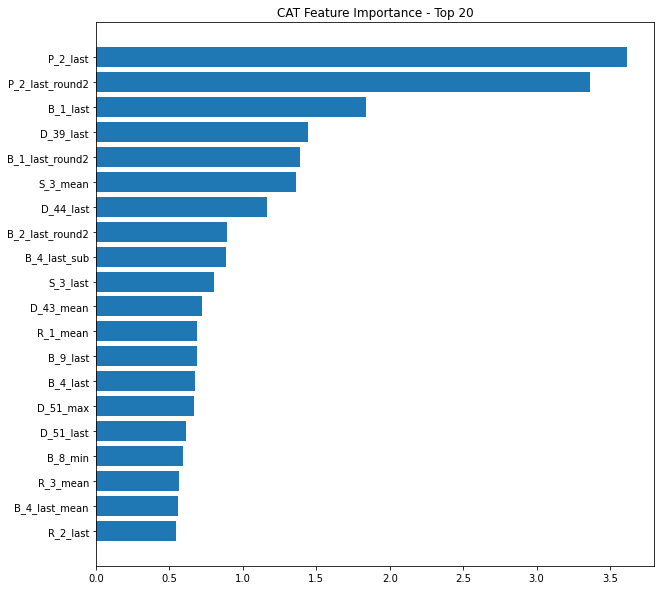

In [ ]:
NUM_FEATURES = 20
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'CAT Feature Importance - Top {NUM_FEATURES}')
plt.show()

# Test part

In [ ]:
# CALCULATE SIZE OF EACH SEPARATE TEST PART
def get_rows(customers, test, NUM_PARTS = 4, verbose = ''):
    chunk = len(customers)//NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        if k==NUM_PARTS-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows,chunk

In [ ]:
# COMPUTE SIZE OF 4 PARTS FOR TEST DATA
NUM_PARTS = 4

customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
rows,num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS = NUM_PARTS, verbose = 'test')

We will process test data as 4 separate parts.
There will be 231155 customers in each part (except the last part).
Below are number of rows in each part:
[231155, 231155, 231155, 231156]


In [ ]:
# INFER TEST DATA IN PARTS
skip_rows = 0
skip_cust = 0
test_preds = []

for k in range(NUM_PARTS):
    # READ PART OF TEST DATA
    print(f'\nReading test data...')
    test_copy = test.iloc[skip_rows:skip_rows+rows[k]].copy()
    test_copy = test_copy.set_index('customer_ID')
    skip_rows += rows[k]
    print(f'=> Test part {k+1} has shape', test_copy.shape )
    
    # PROCESS AND FEATURE ENGINEER PART OF TEST DATA
    if k==NUM_PARTS-1: test_copy = test_copy.loc[customers[skip_cust:]]
    else: test_copy = test_copy.loc[customers[skip_cust:skip_cust+num_cust]]
    skip_cust += num_cust
        
    # INFER XGB MODELS ON TEST DATA
    model = CatBoostClassifier(**cat_params)
    model.load_model(f'CAT_v{VER}_fold0.cbm')
    preds = model.predict_proba(test_copy)[:, 1]
    for f in range(1,FOLDS):
        model.load_model(f'CAT_v{VER}_fold{f}.cbm')
        preds += model.predict_proba(test_copy)[:, 1]
    preds /= FOLDS
    test_preds.append(preds)

    # CLEAN MEMORY
    del test_copy, model
    _ = gc.collect()

del test
_ = gc.collect()


Reading test data...
=> Test part 1 has shape (231155, 2531)

Reading test data...
=> Test part 2 has shape (231155, 2531)

Reading test data...
=> Test part 3 has shape (231155, 2531)

Reading test data...
=> Test part 4 has shape (231156, 2531)


# Submit

In [ ]:
# WRITE SUBMISSION FILE
test = pd.DataFrame(index=customers,data={'prediction': np.concatenate(test_preds)})
sub = pd.read_csv('/content/sample_submission.csv')[['customer_ID']]
sub['customer_ID_hash'] = sub['customer_ID'].copy()
sub = sub.set_index('customer_ID_hash')
sub = sub.merge(test[['prediction']], left_index=True, right_index=True, how='left')
sub = sub.reset_index(drop=True)

# DISPLAY PREDICTIONS
sub.to_csv(f'submission_cat_v{VER}_seed{SEED}_fold{FOLDS}.csv',index=False)
print('Submission file shape is', sub.shape )
sub.head()

Submission file shape is (924621, 2)


,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.015382
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.001268
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.036810
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.194488
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.857730


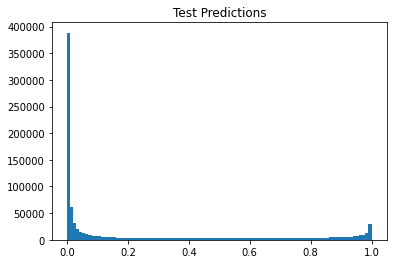

In [ ]:
# PLOT PREDICTIONS
plt.hist(sub.prediction, bins=100)
plt.title('Test Predictions')
plt.show()

# Submit to Kaggle from Colab

In [ ]:
# Submit
!kaggle competitions submit -c amex-default-prediction -f submission_cat_v7_seed42_fold5.csv -m "Run with max - last"

100% 75.3M/75.3M [00:09<00:00, 8.34MB/s]
Successfully submitted to American Express - Default Prediction

In [ ]:
# Run after few seconds
!kaggle competitions submissions amex-default-prediction

fileName                            date                 description                                               status    publicScore  privateScore  
----------------------------------  -------------------  --------------------------------------------------------  --------  -----------  ------------  
submission_cat_v7_seed42_fold5.csv  2022-08-01 06:24:15  Run with max - last                                       complete  0.796                      
Amex Default Prediction - Ensemble  2022-07-30 15:42:45  Notebook Amex Default Prediction - Ensemble | Version 35  complete  0.798                      
Amex Default Prediction - Ensemble  2022-07-30 15:38:09  rank                                                      complete  0.798                      
Amex Default Prediction - Ensemble  2022-07-30 15:36:03  mean ver                                                  complete  0.798                      
Amex Default Prediction - Ensemble  2022-07-30 15:19:03  Notebook Amex Default Pre